In [1]:
import os, sys
%env LD_LIBRARY_PATH=/usr/local/cuda-8.0/lib64
%env LIBRARY_PATH=/usr/local/cuda-8.0/lib64
%env PATH=/usr/local/cuda-8.0/include:/usr/local/cuda-8.0/bin:/home/apanin/anaconda/bin:/opt/WinCC_OA/3.11/bin:/opt/pvss/pvss2_v3.8/bin:/home/apanin/anaconda/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/opt/fmc/bin:/group/online/bin:/group/online/scripts:/home/apanin/bin:/home/apanin/bin
sys.path.insert(0,"/home/apanin/rit_my/")
%env CUDA_VISIBLE_DEVICES=0
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cuda0,gpuarray.preallocate=0.99


env: LD_LIBRARY_PATH=/usr/local/cuda-8.0/lib64
env: LIBRARY_PATH=/usr/local/cuda-8.0/lib64
env: PATH=/usr/local/cuda-8.0/include:/usr/local/cuda-8.0/bin:/home/apanin/anaconda/bin:/opt/WinCC_OA/3.11/bin:/opt/pvss/pvss2_v3.8/bin:/home/apanin/anaconda/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin:/opt/fmc/bin:/group/online/bin:/group/online/scripts:/home/apanin/bin:/home/apanin/bin
env: CUDA_VISIBLE_DEVICES=0
env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cuda0,gpuarray.preallocate=0.99


In [2]:
import theano
import theano.tensor as T
import lasagne
import lasagne.layers as L

Using cuDNN version 6021 on context None
Preallocating 11596/12207 Mb (0.950000) on cuda0
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:02:00.0)


## preprocess

In [3]:
!./preprocess.sh data/indomain_training/indomain.de-en.de preprocessed/ en de
!./preprocess.sh data/indomain_training/indomain.de-en.en preprocessed/ de en

Tokenizer Version 1.1
Language: en
Number of threads: 1
Tokenizer Version 1.1
Language: de
Number of threads: 1


In [3]:
SRC_PATH = "data/wmt/train.tok.bpe.32000.en" 
DST_PATH = "data/wmt/train.tok.bpe.32000.de" 

In [4]:
raw_src = []
with open(SRC_PATH, 'r') as f:
    raw_src = f.readlines()
raw_dst = []
with open(DST_PATH, 'r') as f:
    raw_dst = f.readlines()

In [5]:
def fix_ends(sents):
    for i in range(len(sents)):
        sents[i] = sents[i][:-2]

In [6]:
fix_ends(raw_src)
fix_ends(raw_dst)

In [7]:
class Vocab:
    def __init__(self, sentences):
        tokens = set()
        for s in sentences:
            tokens.update(s.split(' '))
        self.tokens = [ "__BOS__","__EOS__", "__PAD__"] + list(tokens)
        self.EOS = 1
        self.BOS = 0 # BOS should be zero to let the model generate starting with zero as an input
        self.PAD = 2
        self.len = len(self.tokens)
        self.token2id = {token: i for i, token in enumerate(self.tokens)}
    def tokenize(self, sentence):
        if not sentence.endswith("__EOS__"):
            sentence += " __EOS__"
        if not sentence.startswith("__BOS__"):
            sentence = "__BOS__ " + sentence
        return [self.token2id[token] for token in sentence.split(' ')]
    def detokenize(self, sentence):
        return " ".join([self.tokens[token] for token in sentence])
    def tokenize_many(self, sentences):
        return [self.tokenize(sent) for sent in sentences]
    def detokenize_many(self, sentences):
        return [self.detokenize(sent) for sent in sentences]

In [8]:
import pickle as pkl
with open("vocabs.pkl", 'rb') as f:
    dst_voc = pkl.load(f)
    src_voc = pkl.load(f)

In [8]:
src_voc = Vocab(raw_src)
dst_voc = Vocab(raw_dst)

In [10]:
X = src_voc.tokenize_many(raw_src)
Y = dst_voc.tokenize_many(raw_dst)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, Y_train, Y_text = train_test_split(X,Y, test_size = 0.05, random_state = 42)

In [13]:
MAX_LEN = 100

In [14]:
from batch_iterator import iterate_minibatches

In [15]:
import numpy as np

In [16]:
np.random.seed(42)

In [17]:
%env KERAS_BACKEND=theano
from keras.preprocessing.sequence import pad_sequences

env: KERAS_BACKEND=theano


Using Theano backend.


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

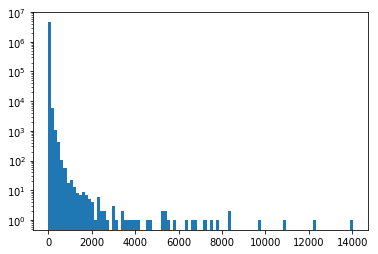

In [19]:
plt.hist(list(map(lambda x: len(x), X)), bins = 100,log=True);

In [20]:
input_sequence = T.matrix('token sequencea','int32')
input_mask = T.neq(input_sequence, src_voc.PAD)

target_values = T.matrix('actual next token','int32')
target_mask = T.neq(target_values, dst_voc.PAD)

In [21]:
CODE_SIZE = 512

In [22]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = lasagne.layers.InputLayer(shape=(None, None),input_var=input_mask)

#encoder
l_emb = L.EmbeddingLayer(l_in, src_voc.len, 128)

l_rnn = L.LSTMLayer(l_emb, 256, nonlinearity=T.tanh, mask_input= l_mask)
l_rnn = L.concat([l_emb,l_rnn], axis=-1)
l_encoded = l_rnn = L.LSTMLayer(l_rnn, CODE_SIZE, nonlinearity=T.tanh, mask_input= l_mask)

l_trans = L.InputLayer((None, None), input_var= target_values[:,:-1])
l_trans_mask = L.InputLayer((None, None), input_var= target_mask[:,:-1])


In [23]:
from agentnet.agent.recurrence import Recurrence
from agentnet.memory import AttentionLayer,LSTMCell 

In [24]:
from agentnet.resolver import ProbabilisticResolver, GreedyResolver

In [25]:
class AutoLSTMCell:
    def __init__(self, input_or_inputs, num_units = None, *args, name=None, **kwargs):
        self.p_cell = L.InputLayer((None, num_units), 
                       name="previous cell state" if name == None else name + " previous cell state")
        self.p_out = L.InputLayer((None, num_units), 
                       name="previous out state" if name == None else name + " previous out state")
        self.cell, self.out = LSTMCell(self.p_cell, self.p_out, input_or_inputs, num_units, *args,name=name, **kwargs)
    def get_automatic_updates(self):
        return {self.cell: self.p_cell, self.out: self.p_out}

In [26]:
class TemperatureResolver(ProbabilisticResolver):
    def __init__(self, incoming, tau, **kwargs):
        self.tau = tau
        super(TemperatureResolver, self).__init__(incoming,**kwargs)
    def get_output_for(self, policy, **kwargs):
        policy = policy ** (1/self.tau)
        policy /= policy.sum()
        return super(TemperatureResolver, self).get_output_for(policy, **kwargs) 

In [27]:
class decoder_step:
    #inputs
    encoder = L.InputLayer((None, None ,CODE_SIZE), name='encoded sequence')
    encoder_mask = L.InputLayer((None, None), name='encoded sequence')
    
    inp = L.InputLayer((None,),name='current character')
    
    l_target_emb = L.EmbeddingLayer(inp, dst_voc.len, 128)
    
    #recurrent part
    
    l_rnn1 = AutoLSTMCell(l_target_emb, 128, name="lstm1")
    
    query = L.DenseLayer(l_rnn1.out, 128, nonlinearity=None)
    attn = AttentionLayer(encoder, query, 128, mask_input= encoder_mask)['attn']
    
    l_rnn = L.concat([attn, l_rnn1.out, l_target_emb])
    
    l_rnn2 = AutoLSTMCell(l_rnn, 128, name="lstm1")
    
    next_token_probas = L.DenseLayer(l_rnn2.out, dst_voc.len, nonlinearity=T.nnet.softmax)
    
    #pick next token from predicted probas
    next_token = ProbabilisticResolver(next_token_probas)
    
    tau = T.scalar("sample temperature", "float32")
    
    next_token_temperatured = TemperatureResolver(next_token_probas, tau)
    next_token_greedy = GreedyResolver(next_token_probas)
    
    auto_updates = {**l_rnn1.get_automatic_updates(),
                    **l_rnn2.get_automatic_updates()}

In [28]:
dst_voc.len

37943

In [29]:
from collections import OrderedDict

In [30]:

training_loop = Recurrence(
    state_variables=OrderedDict(decoder_step.auto_updates),
    input_sequences=OrderedDict({decoder_step.inp:l_trans}), 
    tracked_outputs=[decoder_step.next_token_probas,],
    input_nonsequences= OrderedDict({decoder_step.encoder: l_encoded, decoder_step.encoder_mask: l_mask} ),
    mask_input=l_trans_mask,
    unroll_scan=False,
)

In [31]:
# Model weights
weights = lasagne.layers.get_all_params(training_loop,trainable=True)
print (weights)

[W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, lstm1.b_to_ingate, lstm1.W_lstm1 previous out state_to_ingate, lstm1.W_ctrl1_to_ingate, lstm1.b_to_forgetgate, lstm1.W_lstm1 previous out state_to_forgetgate, lstm1.W_ctrl1_to_forgetgate, lstm1.b_to_cell, lstm1.W_lstm1 previous out state_to_cell, lstm1.W_ctrl1_to_cell, lstm1.b_to_outgate, lstm1.W_lstm1 previous out state_to_outgate, lstm1.W_ctrl1_to_outgate, lstm1.W_cell_to_ingate_peephole.scales, lstm1.W_cell_to_forgetgate_peephole.scales, lstm1.W_cell_to_outgate_peephole.scales, W, b, enc_to_hid, dec_to_hi

In [32]:
train_probas_flat = L.get_output(training_loop[decoder_step.next_token_probas]).reshape((-1,dst_voc.len))

In [33]:
loss = lasagne.objectives.categorical_crossentropy(train_probas_flat, target_values[:,1:].reshape((-1,)))
loss = loss.reshape((-1,target_mask.shape[1]-1))
loss = (loss * target_mask[:,1:]).sum(axis= 1).mean()
updates = lasagne.updates.adam(loss, weights, learning_rate=1e-4)

In [34]:
loss = lasagne.objectives.categorical_crossentropy(train_probas_flat, target_values[:,1:].reshape((-1,)))
loss = (loss * target_mask[:,1:].ravel()).sum() / target_mask.sum()
updates = lasagne.updates.adam(loss, weights, learning_rate=1e-4)

In [35]:
#training
train = theano.function([input_sequence, target_values], loss
                        , updates=updates+training_loop.get_automatic_updates(), allow_input_downcast=True)


ERROR (theano.gof.opt): Optimization failure due to: local_reshape_dimshuffle
ERROR (theano.gof.opt): node: Reshape{2}(InplaceDimShuffle{0,x}.0, HostFromGpu(gpuarray).0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/apanin/anaconda/envs/py35/lib/python3.5/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/home/apanin/anaconda/envs/py35/lib/python3.5/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/home/apanin/anaconda/envs/py35/lib/python3.5/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/home/apanin/anaconda/envs/py35/lib/python3.5/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization

In [36]:
n_steps = T.scalar(dtype='int32')
feedback_loop = Recurrence(
    state_variables=OrderedDict({**decoder_step.auto_updates,
                     decoder_step.next_token:decoder_step.inp}),
    tracked_outputs=[decoder_step.next_token_probas, decoder_step.next_token],
    input_nonsequences= OrderedDict({decoder_step.encoder: l_encoded, decoder_step.encoder_mask: l_mask} ),
    batch_size=input_sequence.shape[0],
    n_steps=n_steps,
    unroll_scan=False,
)

In [37]:
generated_tokens = L.get_output(feedback_loop[decoder_step.next_token])

generate_sample = theano.function([input_sequence ,n_steps],generated_tokens,
                                  updates=feedback_loop.get_automatic_updates())

In [38]:
feedback_loop_greedy = Recurrence(
    state_variables=OrderedDict({**decoder_step.auto_updates,
                     decoder_step.next_token_greedy:decoder_step.inp}),
    tracked_outputs=[decoder_step.next_token_probas, decoder_step.next_token_greedy],
    input_nonsequences= OrderedDict({decoder_step.encoder: l_encoded, decoder_step.encoder_mask: l_mask} ),
    batch_size=input_sequence.shape[0],
    n_steps=n_steps,
    unroll_scan=False,
)

In [39]:
generated_tokens_greedy = L.get_output(feedback_loop_greedy[decoder_step.next_token_greedy])

generate_sample_greedy = theano.function([input_sequence ,n_steps],generated_tokens_greedy,
                                  updates=feedback_loop_greedy.get_automatic_updates())

In [40]:
feedback_loop_temp = Recurrence(
    state_variables=OrderedDict({**decoder_step.auto_updates,
                     decoder_step.next_token_temperatured:decoder_step.inp}),
    tracked_outputs=[decoder_step.next_token_probas, decoder_step.next_token_temperatured],
    input_nonsequences= OrderedDict({decoder_step.encoder: l_encoded, decoder_step.encoder_mask: l_mask} ),
    batch_size=input_sequence.shape[0],
    n_steps=n_steps,
    unroll_scan=False,
)

In [41]:
generated_tokens_temp = L.get_output(feedback_loop_temp[decoder_step.next_token_temperatured])

generate_sample_temp = theano.function([input_sequence ,n_steps, decoder_step.tau],generated_tokens_temp,
                                  updates=feedback_loop_temp.get_automatic_updates())

In [42]:
def translate(src, N=MAX_LEN,t=1,n_snippets=1, greedy=False):
    src = [src_voc.tokenize(src)]
    
    snippets = []
    for _ in range(n_snippets):
        sample_ix = generate_sample_greedy(src, N)[0] if greedy else generate_sample_temp(src, N, t)[0]
        random_snippet = dst_voc.detokenize(sample_ix)
        if random_snippet.find("__EOS__") > 0:
            random_snippet = random_snippet[:random_snippet.find("__EOS__")+1]
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets).replace("@@ ", ''))

In [49]:
print(raw_src[100])
translate(raw_src[100], t = 0.1)

I should now like to comment on the issue itself 
----
 Ich möchte auch auf der Frage der Frage  _ 
----


In [44]:
weights_dict = {str(i): weight for i, weight in enumerate(weights)}

In [45]:
with np.load("weights.npz") as f:
    for key in weights_dict:
        weights_dict[key].set_value(f[key])

In [50]:
from tqdm import tqdm

In [51]:
from IPython.display import clear_output

In [52]:
cost = [];

In [53]:
from time import sleep

In [54]:
from tqdm import tqdm

4.43726015091:   0%|          | 1/86679.92 [00:19<457:29:52, 19.00s/it]

Sent:
It does this with suppliers web@@ mails in co@@ .@@ uk or com@@ .@@ fr 
Real translation
Dies funktioniert es mit den Web@@ mail Anbieter in com@@ .@@ fr co@@ .@@ uk oder 
translated
----
 Sie haben ein und der Web-.-...info  _; Dieser von Ihrer persönlichen Daten in der Suche nach der Online-Website - und für Sie  _ 
----
Epoch 0 average loss = 4.422812223434448


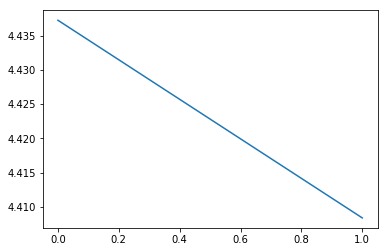

4.52462807655:   0%|          | 320/86679.92 [10:23<46:43:23,  1.95s/it]

In [ ]:
n_epochs = 100
batch_size = 50
view_window = 500

for epoch in range(n_epochs):
    tq = tqdm(iterate_minibatches(X_train,Y_train, batchsize=batch_size, shuffle= True),
              total= len(X_train) / batch_size)
    for x, y in tq:
        padded_x = pad_sequences(x, value= src_voc.PAD, maxlen=MAX_LEN, padding="post")
        padded_y = pad_sequences(y, value= dst_voc.PAD, maxlen=MAX_LEN, padding="post")
        try:
            cost += [train(padded_x[:,:MAX_LEN], padded_y[:,:MAX_LEN])]#!!! fix
            if len(cost) % 10 == 1:
                tq.set_description(str(np.mean(cost[-50:])))
            if len(cost) % view_window == 2:
                translating_ind = np.random.randint(len(raw_src))

                print("Sent:")
                print(raw_src[translating_ind])
                print("Real translation")
                print(raw_dst[translating_ind])
                print("translated")
                translate(raw_src[translating_ind],n_snippets=2, t=0.5)

                print("Epoch {} average loss = {}".format(epoch, np.mean(cost[-view_window:])))
                plt.plot(cost[-view_window:])
                plt.show()
        except KeyboardInterrupt:
            tq.close()
            raise KeyboardInterrupt
        except Exception as e:
            sleep(1)
            print(e)
            print(max(list(map(len, x))))
            print(max(list(map(len, y))))
            #raise e

In [253]:
weights_dict = {str(i): weight for i, weight in enumerate(weights)}

In [291]:
#np.savez("weights.npz", **{key: weights_dict[key].get_value() for key in weights_dict})

In [256]:
with np.load("weights.npz") as f:
    for key in weights_dict:
        weights_dict[key].set_value(f[key])

In [281]:
v = Vocab(raw_dst)
v1 = Vocab(raw_src)

v.tokens = dst_voc.tokens
v1.tokens = src_voc.tokens


In [282]:
"""import pickle as pkl
with open("vocabs.pkl", 'wb') as f:
    pkl.dump(v,f)
    pkl.dump(v1,f)"""

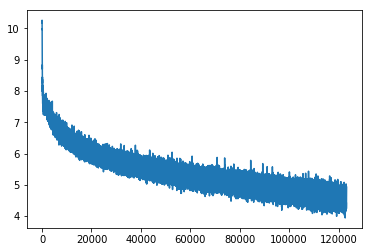

In [287]:
plt.plot(cost[:]);

In [221]:
translating_ind = np.random.randint(len(raw_src))

In [272]:
print(raw_src[translating_ind])
print(raw_dst[translating_ind])
translate(raw_src[translating_ind],n_snippets=1, t=0.1, greedy=False)

This clas@@ h is not inevitable , and we don &apos;t want it 
Bitte sehen Sie sich unser neues Video an und unterzeichnen Sie die folgende Peti@@ tion . Wenn sich die politischen Führer Ende März treffen , wird ihnen unsere Botschaft auf eine Art und Weise zu@@ gestellt werden , die sie nicht ignorieren können ..
----
 Das ist nicht nur , und wir sind nicht nur nicht zu tun  _ 
----


In [202]:
padded_x[1]

array([    1, 26074,   190,     0,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,
           2,     2,     2,     2,     2,     2,     2,     2,     2,     2], dtype=int32)